# Math 377 Fall 2018

#### Name: Lydia Knutson
#### Section: M3

**Documentation Statement:** I compared answers with C2C Matt Doudnikoff and Kelly Grier. In particular, I had trouble with what is line 42 of my code and the conversion of the table in the last section into panda and discussed these two sections with Matt Doudnikoff.

#### Note:
The code through the first 4 sections is provided. Review it first and then begin work on Section 5.

# Project: Predicting Spam
### Data Collection, Summarization, Inference and Prediction

<img style="float: right;" src="img\spam3.jpg">
This project is designed to cover many of the main ideas of the entire course. Ultimately we want to predict if an email is spam. In the course of doing this, we will collect data, clean it up, work with string data, make a simple inference, and then build a naive bayes model from the ground up. 


By the end of project, you should know how to:

1. Find and import data.
2. Use regular expressions to edit string data.
3. Determine if a word helps to identify an email as spam or not.
4. Create a function to predict the type of email using the ideas of Bayesian Classification.
5. Assess your model and propose improvements.

**Advice.** Develop your answers incrementally. To perform a complicated table manipulation, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect by displaying it. You can add additional names or functions to the provided cells in order to organize your work. 

**Authorized Resources:** Anyone and anything.

### 0. Notebook Setup  

Create a folder on your local drive and place this notebook in it. Create a subfolder called `data` copy the file `subject_lines.csv` into it from our Google drive. Create another subfolder called `img` and copy `spam3.jpg` into it, this file can also be found on the Google drive.

### 1. Background Information 

There are a couple of reference papers that may be of interest to explore. The first is "Better Bayesian Filtering" by Paul Graham,http://bit.ly/1ycPbiy. The second is "A Plan for Spam" also by Paul Graham, http://bit.ly/1ycPcmA

### 2. Load Packages  

To get started, load `datascience`, `numpy`, `mathplotlib.pyplot`, `math`, `re`, and `pandas`.

In [1]:
# Execute this line as written
import datascience as ds #note the labs use from datascience import * but this is not a good practice
import numpy as np
import pandas as pd
import re
import math
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

### 3. Get Data

We are going to use data from the [Apache SpamAssasian](https://spamassassin.apache.org/) website. In particular we want data from their public corpus; see the readme document at https://spamassassin.apache.org/old/publiccorpus/.

We have provided you with a csv file that contains two columns. The first is the subject line and the second is whether the email is spam.

Read in the data. It can be found on the Google drive with the name `subject_lines.csv`. Don't forget that you have imported the `datascience` package under the alias `ds`. 

In [2]:
# Complete the code to read in the data
Spam_data_table = ds.Table.read_table('subject_lines.csv')
Spam_data_table

Subject Line,Spam
Re: New Sequences Window,False
[zzzzteana] RE: Alexander,False
[zzzzteana] Moscow bomber,False
[IRR] Klez: The Virus That Won't Die,False
Re: Insert signature,False
Re: [zzzzteana] Nothing like mama used to make,False
Re: [zzzzteana] Nothing like mama used to make,False
[zzzzteana] Playboy wants to go out with a bang,False
Re: [zzzzteana] Nothing like mama used to make,False
[zzzzteana] Meaningful sentences,False


Let's get a count of the emails. Use the group command to get a count of spam and ham emails.

In [3]:
# Complete the code
Spam_data_table.group("Spam")

Spam,count
False,2800
True,500


### 4. Feature Engineering  

We are dealing with string data as our predictor. We first need to clean it up. The choices we make here will potentially have a big impact on the quality of the model. Ideally we would go back and test the sensitivity of our results to these choices.

First we will make all the text lower case. This will ensure that words such as Free and free are viewed as equivalent. This may not be a good idea for spam detection as a word in all capital letters might be more indicative of spam.  

We will be dealing with frequencies in this project but we could also try other ideas such as vector encoding and $n$-grams.

#### Clean Data

We will first get the subject lines in a standard format with lower cases, no punctuation, and the removal of stopwords.

In [4]:
# Example of the function we need. Execute this line
'FREE'.lower()

'free'

Next, we need to tokenize our string. This means to split the string into a list of words. This requires the use of regular expressions, https://docs.python.org/2/library/re.html. 

We will also need to remove stop words. Stop words are common words such as `and` or `we`, that add little predictive ability. We will load the natural langauge tool kit package, `nltk`, to get a list of stop words. If you are having trouble loading the `nltk` package we also provide the stop words as a csv file.

#### Using nltk package, the preferred method

In [5]:
# Execute the following commands
import nltk

nltk.download('stopwords')

# Getting the English stop words from nltk
stop_words = nltk.corpus.stopwords.words('english')

# Printing out the first eight stop words
print(stop_words[:8])

#We will convert our stopwords to a set as set lookup is much faster

stop_words = set(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\C20Lydia.Knutson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves']


#### Using a csv file, the backup method

In [6]:
stop_words = set(pd.read_csv('stop_words.csv')["stopwords"].tolist())

Strip off unwanted text from subject line

In [7]:
# Execute this line as is
# Using data science table to demenostrate how to make lower case and keep only words and numbers
print(Spam_data_table.take(np.arange(5)))
print("\n")
for subject in Spam_data_table.take(np.arange(5)).column(0):
    print(re.findall("[a-z0-9']+",subject.lower()))

Subject Line                          | Spam
Re: New Sequences Window              | False
[zzzzteana] RE: Alexander             | False
[zzzzteana] Moscow bomber             | False
[IRR] Klez: The Virus That  Won't Die | False
Re: Insert signature                  | False


['re', 'new', 'sequences', 'window']
['zzzzteana', 're', 'alexander']
['zzzzteana', 'moscow', 'bomber']
['irr', 'klez', 'the', 'virus', 'that', "won't", 'die']
['re', 'insert', 'signature']


Let's remove the stop words and split the string into words. We will run some test code on the first 5 lines for illustration.

In [8]:
# Testing code, run this line of code
for subject in Spam_data_table.take(np.arange(5)).column(0):
    final_words = []
    print("Original subject line: ",subject)
    print("Split line: ",re.findall("[a-z0-9']+",subject.lower()))
    words = re.findall("[a-z0-9']+",subject.lower())
    [final_words.append(word) for word in words if word not in stop_words]
    print("Clean line: ",final_words)

Original subject line:  Re: New Sequences Window
Split line:  ['re', 'new', 'sequences', 'window']
Clean line:  ['new', 'sequences', 'window']
Original subject line:  [zzzzteana] RE: Alexander
Split line:  ['zzzzteana', 're', 'alexander']
Clean line:  ['zzzzteana', 'alexander']
Original subject line:  [zzzzteana] Moscow bomber
Split line:  ['zzzzteana', 'moscow', 'bomber']
Clean line:  ['zzzzteana', 'moscow', 'bomber']
Original subject line:  [IRR] Klez: The Virus That  Won't Die
Split line:  ['irr', 'klez', 'the', 'virus', 'that', "won't", 'die']
Clean line:  ['irr', 'klez', 'virus', 'die']
Original subject line:  Re: Insert signature
Split line:  ['re', 'insert', 'signature']
Clean line:  ['insert', 'signature']


#### Subject Line Frequency  

Before going further with inference or prediction, let's summarize the data. We want to count the total number of times a word occurrs in a subject line separately in both the spam and ham data sets. We need to count the word once per subject line.

Write a function to tokenize each subject line. This means reducing to lower case, removing stop words, and then splits into individual words. Use the code in the previous line as an example.

In [9]:
# Complete this function
def token(subject,sw=stop_words):
    words = re.findall("[a-z0-9']+",subject.lower())
    return set([word for word in words if word not in sw])

First let's run some code on a subset, the first 3 lines, of the data. We need to get the subject line column, tokenize it, and then flatten into a list instead of a list of lists.

In [10]:
# Run this code
# Get the first 5 subject lines for spam
spam_subjects = Spam_data_table.where('Spam',True).take(np.arange(5)).column(0)
#Tokenize and then append
spam_words=[]
for subject in spam_subjects[:3]:
    spam_words.append(token(subject,stop_words))
print("List after using token: ",spam_words,"\n")
#Create one long list of words
spam_words = [item for sublist in spam_words for item in sublist]
print("The flattened list: ",spam_words)

List after using token:  [{'pay', 'life', 'insurance'}, {'12', 'lbs', '10', '30', 'ilug', 'days', 'lose', '206', 'guaranteed'}, {'11', '12', 'lbs', '10', '30', '150', 'days', 'lose', 'guaranteed'}] 

The flattened list:  ['pay', 'life', 'insurance', '12', 'lbs', '10', '30', 'ilug', 'days', 'lose', '206', 'guaranteed', '11', '12', 'lbs', '10', '30', '150', 'days', 'lose', 'guaranteed']


Now that you have created code to generate a list of spam words taken from the first 3 subject lines, copy and paste the above snippet and modify it below to go through ALL spam. Note that you should no longer print the lists. 

In [11]:
#Get the subject lines for spam
spam_subjects = Spam_data_table.where('Spam',True).column(0)
#Tokenize and then append
spam_words=[]
for subject in spam_subjects:
    spam_words.append(token(subject,stop_words))
spam_words = [item for sublist in spam_words for item in sublist]
print("There are",len(spam_words),"tokenized words in the spam subject lines.")

There are 2408 tokenized words in the spam subject lines.


We can tokenize multiple subjects with the apply function.

In [12]:
# Run code
# Using apply function in datascience
Spam_data_table.take(np.arange(5)).with_columns("Subject",Spam_data_table.take(np.arange(5)).apply(token,"Subject Line")).\
drop(0).select("Subject","Spam").relabel("Subject","Subject Line")

Subject Line,Spam
"{'sequences', 'window', 'new'}",False
"{'alexander', 'zzzzteana'}",False
"{'bomber', 'moscow', 'zzzzteana'}",False
"{'die', 'virus', 'klez', 'irr'}",False
"{'insert', 'signature'}",False


Using the snippet above as an example, tokenize all subjects from spam e-mails only.

In [13]:
# Now for the entire table
Spam_data_table_spamonly = Spam_data_table.where('Spam',True)
Spam_data_table_token = Spam_data_table_spamonly.with_columns("Subject",Spam_data_table_spamonly.\
    apply(token,"Subject Line")).drop(0).select("Subject","Spam").relabel("Subject","Subject Line")
Spam_data_table_token

Subject Line,Spam
"{'pay', 'life', 'insurance'}",True
"{'12', 'lbs', '10', '30', 'ilug', 'days', 'lose', '206', ...",True
"{'11', '12', 'lbs', '10', '30', '150', 'days', 'lose', ' ...",True
"{'name', 'fw', 'user', 'membership', 'sites', 'com', 'pv ...",True
"{'social', '12', 'lbs', '10', '30', '148', 'ilug', 'days ...",True
"{'bank', 'account', 'information'}",True
"{'reps', 'fortune', '500', 'company', 'home', 'hiring'}",True
"{'protected', 'family'}",True
"{'important', 'concerning', 'bank', 'account', 'informat ...",True
"{'customer', 'base', 'multiply'}",True


Now that we've tokenized all of the spam e-mails, get the frequency of each of the words that appears in spam.

In [14]:
# Get counts and frequency
# Flatten first
spam_words = [item for sublist in Spam_data_table_token.column(0) for item in sublist]
# Put into a table
spam_table = ds.Table().with_columns("Words",spam_words)
spam_word_counts = spam_table.group('Words').sort('count',descending=True).relabel('count','Spam Count')
spam_word_counts.show(5)

Words,Spam Count
ilug,46
free,32
get,20
adv,20
rates,18


In [15]:
print("There are",spam_word_counts.num_rows,"unique words in the tokenized spam subject lines.")

There are 1135 unique words in the tokenized spam subject lines.


Next we want to create a column that has the subject line frequency of each word. This is the percentage of subject lines in the spam emails that contain the word of interest. We also sort the table from most frequent to least frequent.

In [16]:
# Execute this cell of code
spam_word_counts = spam_word_counts.with_column('Spam Subject Line Frequency',spam_word_counts.column('Spam Count')/500).\
set_format("Spam Subject Line Frequency", ds.NumberFormatter(decimals=4))
spam_word_counts

Words,Spam Count,Spam Subject Line Frequency
ilug,46,0.0920
free,32,0.0640
get,20,0.0400
adv,20,0.0400
rates,18,0.0360
home,18,0.0360
money,17,0.0340
best,17,0.0340
systemworks,15,0.0300
2002,15,0.0300


To summarize, 9.2% of the subject lines in the spam emails contain the word `ilug`. As a reminder, the vocabulary of words in the spam subject line consists of 2408 words where 1135 are unique words.

In [17]:
spam_word_counts.num_rows

1135

Find the total of the spam word count column in `spam_word_counts`. 

In [18]:
sum_spam_word_counts = sum(spam_word_counts.column('Spam Count'))
sum_spam_word_counts

2408

Some of the words only occur once. Let's look at some of them.

In [19]:
# Create a table of words where the word only occurs once. There should be three columns, words, spam count and frequency.
spam_word_one = spam_word_counts.where('Spam Count',1)
spam_word_one

Words,Spam Count,Spam Subject Line Frequency
zzzzason,1,0.0020
zzzz8969,1,0.0020
zbm,1,0.0020
ytu855,1,0.0020
yr,1,0.0020
youth,1,0.0020
younger,1,0.0020
york,1,0.0020
yeni,1,0.0020
ya,1,0.0020


To visualize the results so far, we will use a bar chart. Create a bar chart showing the frequency of the 15 most frequent words that appear in spam subject lines.

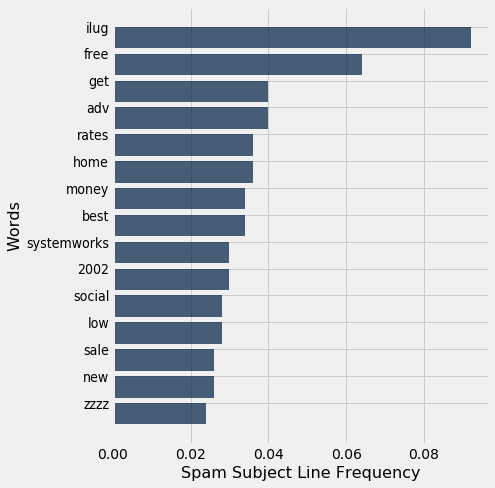

In [20]:
# Create a horizontal bar chart
spam_word_counts.take(np.arange(15)).barh('Words',select="Spam Subject Line Frequency")

### Ham e-mails

Repeat this work for the ham e-mails. First, tokenize the ham subject lines.

In [21]:
Ham_data_table_hamonly = Spam_data_table.where('Spam',False)
Ham_data_table_token = Ham_data_table_hamonly.with_columns("Subject",Ham_data_table_hamonly.\
    apply(token,"Subject Line")).drop(0).select("Subject","Spam").relabel("Subject","Subject Line")
Ham_data_table_token

Subject Line,Spam
"{'sequences', 'window', 'new'}",False
"{'alexander', 'zzzzteana'}",False
"{'bomber', 'moscow', 'zzzzteana'}",False
"{'die', 'virus', 'klez', 'irr'}",False
"{'insert', 'signature'}",False
"{'used', 'nothing', 'zzzzteana', 'mama', 'like', 'make'}",False
"{'used', 'nothing', 'zzzzteana', 'mama', 'like', 'make'}",False
"{'zzzzteana', 'wants', 'playboy', 'bang', 'go'}",False
"{'used', 'nothing', 'zzzzteana', 'mama', 'like', 'make'}",False
"{'sentences', 'meaningful', 'zzzzteana'}",False


Find the word counts for words that appeared in ham subject lines.

In [22]:
# Get counts and frequency
# Flatten first
ham_words = [item for sublist in Ham_data_table_token.column(0) for item in sublist]
# Put into a table
ham_table = ds.Table().with_columns("Words",ham_words)
ham_word_counts = ham_table.group('Words').sort('count',descending=True).relabel('count','Ham Count')
ham_word_counts.show(5)

Words,Ham Count
satalk,141
spambayes,135
new,117
users,108
2,108


In [23]:
print("There are",ham_word_counts.num_rows,"unique words in the tokenized ham subject lines.")

There are 3727 unique words in the tokenized ham subject lines.


In [24]:
sum_ham_word_counts = sum(ham_word_counts.column('Ham Count'))
print("There are",sum_ham_word_counts,"tokenized words in the ham subject lines.")

There are 12163 tokenized words in the ham subject lines.


In [25]:
ham_word_counts = ham_word_counts.with_column('Ham Subject Line Frequency',ham_word_counts.column('Ham Count')/2800).\
set_format("Ham Subject Line Frequency", ds.NumberFormatter(decimals=4))
ham_word_counts

Words,Ham Count,Ham Subject Line Frequency
satalk,141,0.0504
spambayes,135,0.0482
new,117,0.0418
users,108,0.0386
2,108,0.0386
ilug,94,0.0336
use,91,0.0325
razor,91,0.0325
2002,89,0.0318
zzzzteana,87,0.0311


Make a barplot showing the frequency of the 15 most frequent words that appear in ham subject lines. 

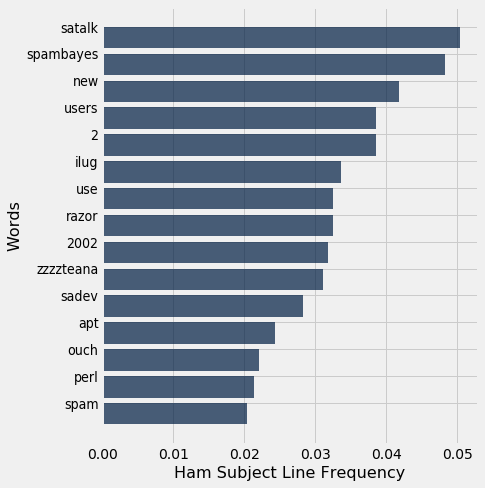

In [26]:
ham_word_counts.take(np.arange(15)).barh('Words',select="Ham Subject Line Frequency")

There are 12163 words in the ham email subject lines of which 3727 are unique. Which words appear only once?

In [27]:
ham_word_one = ham_word_counts.where('Ham Count',1)
ham_word_one

Words,Ham Count,Ham Subject Line Frequency
zoo,1,0.0004
zone,1,0.0004
zombies,1,0.0004
zen,1,0.0004
zealots,1,0.0004
yup,1,0.0004
youth,1,0.0004
youngest,1,0.0004
yoga,1,0.0004
yet,1,0.0004


As a reminder, in the spam subject line there are 1135 unique words while there are 3727 in the ham. When we merge these data sets there will only be partial overlap.

In [28]:
spam_word_counts.num_rows #Number of unique words in spam subject lines

1135

In [29]:
ham_word_counts.num_rows #Number of unique words in ham subject lines

3727

There are many more words in the ham subject lines than in the spam subject lines. We need to get one table with the words and counts. This will increase the number of rows for the spam. The built-in join function from the `datascience` package only performs an inner joining. We need to perform an outer join. We cannot determine how to do this with the join function from `datascience` so let's convert the table to pandas dataframes and then perform an outer join, see https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/. By default, pandas repalces missing values with NaN, not a number. We must replace those missing values with 0. Finally, we can convert back to a datascience table.

In [30]:
# Execute this cell
# Convert data.science table to pandas dataframe
word_counts = pd.merge(ham_word_counts.to_df(),spam_word_counts.to_df(),how="outer").fillna(0)
word_counts = ds.Table.from_df(word_counts)
word_counts

Words,Ham Count,Ham Subject Line Frequency,Spam Count,Spam Subject Line Frequency
satalk,141,0.0503571,1,0.002
spambayes,135,0.0482143,0,0
new,117,0.0417857,13,0.026
users,108,0.0385714,0,0
2,108,0.0385714,3,0.006
ilug,94,0.0335714,46,0.092
use,91,0.0325,2,0.004
razor,91,0.0325,0,0
2002,89,0.0317857,15,0.03
zzzzteana,87,0.0310714,0,0


Let's visualize the results by looking at the most common words in the ham subject lines.

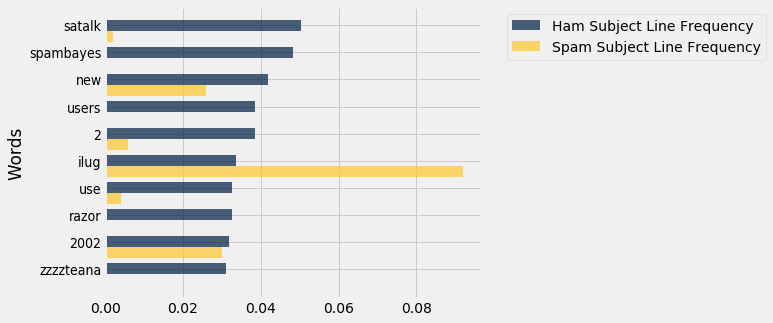

In [31]:
# Execute this cell
word_counts.take(np.arange(10)).select('Words','Ham Subject Line Frequency','Spam Subject Line Frequency').barh('Words')

Now, create the same visualization but with the most common words in the spam emails. 

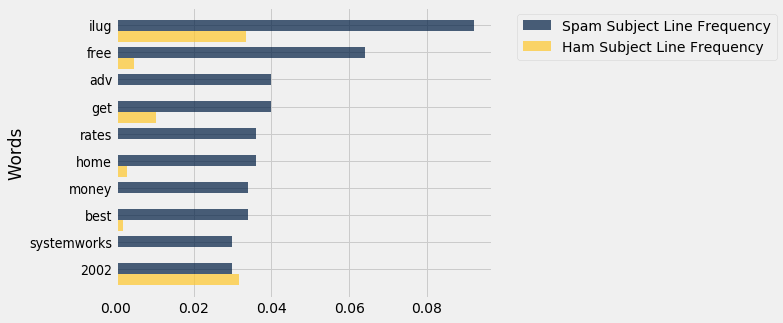

In [32]:
word_counts.sort('Spam Subject Line Frequency',descending=True).\
take(np.arange(10)).select('Words','Spam Subject Line Frequency','Ham Subject Line Frequency').barh('Words')

What do you notice about words that appear in spam and ham e-mail subject lines? 

There are some key words that occur frequently in spam but not in ham. An example is the word free. Some are frequent in both and may not add much predictive value, for example 2002. 

#### References


https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/
http://localhost:8888/notebooks/Documents/Classes/Books/Stats/Python%20Data%20Science%20Handbook/PythonDataScienceHandbook-master/notebooks/05.05-Naive-Bayes.ipynb

### 5. Inference

From personal experience of recieving many spam emails over the years, we beleive that the word free appears in spam emails much more often than in regular, ham, emails. Let's test this hypothesis using our data.

First let's get the data. Note: We already have all the data in the above horizontal bar plot.  

Run all the cells prior to this one to load the data. This assumes your data files are in the same folder as this notebook.

Get the counts of the words free from the word_counts table.

In [33]:
# Complete the code
word_counts.where('Words','free')

Words,Ham Count,Ham Subject Line Frequency,Spam Count,Spam Subject Line Frequency
free,13,0.00464286,32,0.064


From the intitial section of this analysis, we found that there were 3300 emails of which 500 are spam. Thus 2800 are ham. Put this data in a table.


In [34]:
# Complete the code
free = ds.Table().with_columns('Word', ds.make_array("Free", "No Free", "Free", "No Free")
                               , 'Type', ds.make_array("Spam","Spam","Ham","Ham"), 
                               'Count',  ds.make_array(sum(word_counts.where('Words','free').column('Spam Count')),
                                                       500-sum(word_counts.where('Words','free').column('Spam Count')),
                                                       sum(word_counts.where('Words','free').column('Ham Count')),
                                                       2800-sum(word_counts.where('Words','free').column('Ham Count'))))
free

Word,Type,Count
Free,Spam,32
No Free,Spam,468
Free,Ham,13
No Free,Ham,2787


Our hypothesis before collecting and summarizing the data was that the word free would appear in spam emails more frequently than in ham emails. Now we have data that supports this as 6.4% of spam emails contain the word free while only 0.46% of ham emails contain it. 

This difference could be due to random chance. Let's perform a hypothesis test to determine the probability of our observed data.

We now construct the framework for our hypothesis test.

> **Null Hypothesis**: Spam emails are equally likely to contain the word "free" as ham emails.

Under the null hypothesis we assume that the word free does not appear more likely in either ham or spam. Remember that ham is much more common than spam, so we need to be careful about our randomization process. 

Prior to collecting data, we suspected that free would appear more often in spam emails. The alternative hypothesis is:

> **Alternative Hypothesis**: Spam emails are more likely to contain the word "free" as compared with ham emails.

*Technical note*: The word frequencies are not random samples from any population of emails so we must be careful about generalizing our results.  For example, most people have not recieved an email with the word 'ilug' in it. 

*Important requirements for our test statistic:* We want to choose a test statistic for which large positive values are evidence in favor of the alternative hypothesis, and other values are evidence in favor of the null hypothesis. This is because once we've determined the direction of our alternative hypothesis, we only care about the tail in that direction. If, for example, our p-value cutoff was 5%, we'd check to see if our observed test statistic fell within the largest 5% of values in our null hypothesis distribution. 

Our test statistic should depend only on whether free is more common in spam than ham. Thus we choose:

> **Test Statistic**: The number of times free appears in the subject line of 500 spam emails minus the number of times free appears in the subject line of 2800 ham emails.

We need to create a data table to sample from. First we need a list of whether the subject line contains free or not and then the email type.

In [35]:
# Execute the following code
word_list=["Free"]*32
word_list.extend(["Not Free"]*468)
word_list.extend(["Free"]*13)
word_list.extend(["Not Free"]*2787)
email=["Spam"]*500
email.extend(["Ham"]*2800)

Create a datascience table with columns Email and Word, in that order.

In [36]:
# Complete the code
inf_tab = ds.Table().with_column('Email',email)
inf_tab=inf_tab.with_column('Word',word_list)
inf_tab

Email,Word
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free


Summarize the data using a pivot table. This is a check that we have created the correct table.

In [37]:
# Complete the code
inf_tab.pivot('Email','Word')

Word,Ham,Spam
Free,13,32
Not Free,2787,468


Next we need to calculate the observed value of our test statistic from the data.

In [38]:
# Complete the code using the inf_tab
observed_difference = 32-13
observed_difference

19

The randomization process must be done carefully. We don't want to take an email and randomly assign the word free as in a coin flip. Instead, if the word free is really independent of the email type then we could shuffle the assignment of the word with the email type. This is how we will do our randomization. 

We will complete the sampling in a manner similar to the work in Lecture Notebook 9 of the second course.

In [39]:
emails = inf_tab.select('Email')
predictor = inf_tab.select('Word')
emails

Email
Spam
Spam
Spam
Spam
Spam
Spam
Spam
Spam
Spam
Spam


For one simulation under the null hypothesis, we get the following result.

In [40]:
# Run the cell
shuffled_predictor = predictor.sample(with_replacement=False).column(0)
shuffled_tbl = emails.with_column('Shuffled Result', shuffled_predictor)
difference = np.diff(shuffled_tbl.pivot("Shuffled Result","Email").column(1))
difference

array([-27])

Now complete the code and run the loop 2000 times to get an empirical distribution of the test statistic.

In [41]:
# Complete the code
differences = ds.make_array()

for _ in np.arange(2000):
    shuffled_predictor = predictor.sample(with_replacement=False).column(0)
    shuffled_tbl = emails.with_column('Shuffled Result', shuffled_predictor)
    new_differences = np.diff(shuffled_tbl.pivot("Shuffled Result","Email").column(1))
    differences = np.append(differences,new_differences)

Now display the results in a histogram with bins that run from -55 to 40 with a width of 5. If you are feeling ambitious, add a red dot for the observed value of the test statistic.

C:\Users\C20Lydia.Knutson\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


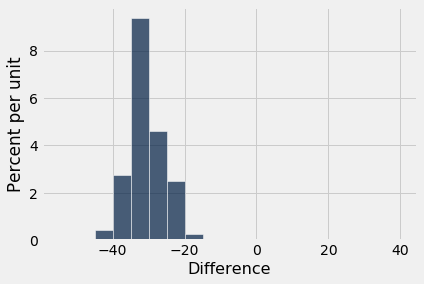

In [42]:
# Complete the code
ds.Table().with_column('Difference', differences).hist(bins=np.arange(-55,41,5), ec='w')
#plots.scatter();

If the null hypothesis were true, then we did not witness a single simulation with a result where the test statistic was positive let alone as high as our observed value of 19. The probability of our observed result is negligible, thus leading us to conclude that the word free appears in spam emails much more often than is expected by chance.

We have to be careful about the assumptions of this test and generalizing the results to a larger population.

This test assumes the percentage of spam emails is 13.16% and that the word free appears in a subject line about 1.3% of the time. We did not alter these percentages in the simulation.

We also assumed the emails are representative of only those emails in the collections. Generalization to a larger population must be cautioned.

### 6. Simple Prediction Model

We will use the word free to make a simple classifier. Our model is this: if the subject line contains the word free, we will classify it as spam, if not, then as ham. Since there is no learning, this is not a machine learning algorithmn. 

We will use the algorithm on all our data and measure the performance. This will help us explore metrics of performance.

The pivot table we derived above gives us all the data we need to explore this simple model.

In [43]:
inf_tab.pivot("Word","Email")

Email,Free,Not Free
Ham,13,2787
Spam,32,468


The predicted outcome of the model uses the rule: predict spam if the subject line contains the the word free. Thus the column called Free could be called Predict Spam and the column Not Free would be Predict Ham. If we, arbitrarily, call the case of an email having the word free as a positive result, then we have 32 true positives. We have 2787 true negatives, 13 false positive, and 468 false negatives. 

One measure of performance is accuracy, how many predictions were correct out of the total. Accuracy is

$$
{(TP + TN) \over (TP + TN + FP + FN)}
$$

Print the predicted accuracy.

In [44]:
print("Accuracy for calling everything ham is: {:.2%}".format((32+2787)/(2787+32+13+468)))

Accuracy for calling everything ham is: 85.42%


Other metrics are the recall and precision. 

Recall is the percentage of all true spam emails that we correctly classified.
$$
{TP \over (TP + FN)}
$$
and precision is the precentage of all predicted spam emails that we correctly classified.

$$
{TP \over (TP + FP)}
$$

Print the estimated recall and precision.

In [45]:
print("Recall is: {:.2%}".format(32/(32+468)))
print("Precision is: {:.2%}".format(32/(32+13)))

Recall is: 6.40%
Precision is: 71.11%


Of the emails that were spam, we only identified 32 of them with our model. 

Of all the emails we called spam, 32 were spam. 

These metrics gives a much different impression of the classifier.

We can combine these as a geometric mean to get a single number, this is called the $F_{1}$ score and is
$$
F_{1}={1 \over {1 \over Precision} + {1 \over Recall}}
$$

Print the observed $F1$ metric.

In [46]:
recall = (32)/(32+468)
precision = (32)/(32+13)
print("F1 score is: {:.2%}".format(1/(1/precision+1/recall)))

F1 score is: 5.87%


Create a function the accepts tp,fp,tn, and fn and prints out the accuracy, precision, recall and F1.

In [47]:
# Complete the code
def classification_performance(tp,fp,tn,fn):
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    print("Accuracy is: {:.2%}".format(accuracy))
    precision = (tp/(tp+fp))
    print("Precision is: {:.2%}".format(precision))
    recall = (tp/(tp+fn))
    print("Recall is: {:.2%}".format(recall))
    F1 = (1/(1/precision+1/recall))
    print("F1 score is: {:.2%}".format(F1))
    return accuracy,precision,recall,F1

Run your function with the numbers from our data.

In [48]:
classification_performance(32,13,2787,468);

Accuracy is: 85.42%
Precision is: 71.11%
Recall is: 6.40%
F1 score is: 5.87%


This is not a good classifier because we are missing so many of the spam emails by predicting they are ham.

As preparation for our naive Bayes classifier, let's look at our results from a probability perspective.

Let's use the table to make some probability calculations. We can estimate probabilities from this table. We have  

$$ P({\rm Free}~| ~{\rm Spam}) = {P({\rm Free} \cap {\rm Spam}) \over P({\rm Spam})} = {32 \over 500}$$   

$$ P({\rm Free}~| ~{\rm Ham}) = {P({\rm Free} \cap {\rm Ham}) \over P({\rm Ham})} = {13 \over 2800}$$   

$$ P({\rm Spam}) = {500 \over 3300}$$   

$$ P({\rm Ham}) = {2800 \over 3300}$$  
 
We could have calculated these next probabilities directly but we will use Bayes Theorem.  

$$ P({\rm Spam}~| ~{\rm Free}) = {P({\rm Free} \cap {\rm Spam}) \over P({\rm Free})} = {P({\rm Free}~| ~{\rm Spam})P({\rm Spam}) \over P({\rm Free})} = {32 \over 45}$$
where
$$P({\rm Free})= P(\rm Free \cap \rm Spam) + P(\rm Free \cap \rm Ham)=P({\rm Free}~| ~{\rm Spam})P({\rm Spam}) + P({\rm Free}~| ~{\rm Ham})P({\rm Ham})$$

In [49]:
# Test the ideas
fgs=32/500
fgh=13/2800
s=500/3300
h=2800/3300

In [50]:
print("The probability of an email being spam given it contains the word free is: {:.2%}".format((fgs*s)/(
    fgs*s+fgh*h)))

The probability of an email being spam given it contains the word free is: 71.11%


To make the model more sophisticated, we could add a second word such as get. The issue here is the we will have to estimate  

$$P({\rm Free} \cap {\rm Get}~ | ~{\rm Spam})$$  

$$P({\rm Free} \cap {\rm Not}~{\rm Get} ~| ~{\rm Spam})$$  

$$P({\rm Not}~{\rm Free} \cap {\rm Get} ~ | ~{\rm Spam})$$  

$$P({\rm Not}~{\rm Free} \cap {\rm Not}~{\rm Get} ~ | ~{\rm Spam})$$  

and likewise for ham. This starts to get difficult quickly. 

A simplifying assumption is needed to reduce the computational difficulty.

### 7. Naive Bayes Classification

Naive Bayes models are based on an extreme assumption of conditional independence. They are fast and easy to implement. They work well with high dimensional data. They work reasonably well in text applications and thus are why we are exploring them. There are really no tuning parameters, so learning is easy. They make a great starting point for a baseline model and sometimes are used as the final model.

This section will implement a naive Bayes model for our spam classification problem.

### Bayesian Classification

This section is based on notes from http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb

Naive Bayes is a Bayesian classification method; these methods use Bayes' theorem. We explored this at the end of Section 6.

In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes' theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

When we write $P({\rm features})$ we mean a joint probability, for example $P({\rm Free} \cap {\rm Get})$.

It is only the numerator that matters as the denominator will be the same in all calculations for the different labels.

For example, suppose we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

Notice that the joint probability, $P(\rm features)$, does not matter. If the ratio is greater than one, then $P(L_1~|~{\rm features})$ is larger and you would select $L_{1}$ as the predicted outcome. You don't need to find the ratio, you simply need to find the maximum of $P(L_i~|~{\rm features})$ for each label.

Next we need an algorithm to compute $P({\rm features}~|~L_i)$ for each label. We could do a lookup table as we did in Section 6 but once we start adding many features this becomes too computationally expensive. The different assumptions about this calculation lead to the different types of Bayesian classifiers. In the naive Bayes model we make the assumption of conditional independence. This means within each label, for example a spam email, each word is independent of the others. This is clearly not going to be the case but the resulting model still has a practical use. 

To implement a naive Bayes classifier, we must only calculate the within label univariate density for continuous features, or probability mass for discrete features. The joint distribution is found by multiplying these univariate distributions. Once the univariate distributions have been estimated, the posterior calculaton is fast. For discrete text data, we only need to estimate the frequency of each word in each label. Then for multiple words we calculate the joint probability as the product of these individual probabilities. For example
$$P({\rm Free} \cap {\rm Get}~ | ~{\rm Spam}) = P({\rm Free}~ | ~{\rm Spam})P({\rm Get}~ | ~{\rm Spam})$$  

There are still some logistical issues to resolve. First, what if a word does not appear in a subject line? This would lead to a zero estimated probability and thus the joint probability would be zero as well. A solution to this problem is to use a psuedocount. This is determined as follows:

$$P({\rm Word}~ |~ {\rm Spam}) = {\mbox{Number of times Word appears in Subject line} + k \over \mbox{Number of Subject lines} +2k}$$  

where $k$ does not need to be an integer.

Second, when we estimate the univariate probabilities, they tend to be small. If the subject has many words, then the product will be extrememly small. We can handle this by working with logarithms.

Finally, we need to get our training and test data. We will attack this next.

#### Test and Training Data

We will divide the data into testing and training data. In general, we use the training data to build a model, and we use the test data to evaluate the model. We have a couple of concerns. Since spam emails are rare, we need to make sure our sampling method selects enough of them. Second it may be the case that the testing set contains a word not in the training set. In this case we can just ignore it or develop a larger vocabulary then is in the training set. We will just ignore the word in our analysis.

Let's start by splitting our data into a training and testing set. We will use 80% of the data in the training, or 2640 emails.

In [51]:
np.random.seed(2020)
shuffled_spam = Spam_data_table.sample(with_replacement=False)
training = shuffled_spam.take(np.arange(2640))
testing = shuffled_spam.take(np.arange(2640, 3300))

In [52]:
training.group("Spam")

Spam,count
False,2232
True,408


In [53]:
testing.group('Spam')

Spam,count
False,568
True,92


In [54]:
# Report Summary of spliting
print("Number of training data points: ",(408+2232))
print("Percent of data in training: {:.2%}".format(2640/3300))
print("Number of Spam in training: ",training.group('Spam').column(1).item(1))
print("Percent of Spam in training: {:.2%}".format(408/500))
print("Number of testing data points: ",(568+92))
print("Number of Spam in testing: ",testing.group('Spam').column(1).item(1))
print("Percent of Spam in testing: {:.2%}".format(92/500))

Number of training data points:  2640
Percent of data in training: 80.00%
Number of Spam in training:  408
Percent of Spam in training: 81.60%
Number of testing data points:  660
Number of Spam in testing:  92
Percent of Spam in testing: 18.40%


We could use the split command as well:

training,testing = Spam_data_table.split(2640)

Look at the training data.

In [55]:
training

Subject Line,Spam
=?big5?Q?re:=A7=DA=AA=BE=B9D=A7A=BB=DD=ADn=A7=F3=A6h=BE= ...,True
Re[2]: AA Meetings the Hottest Place to Meet Women With ...,False
Re: [Razor-users] Using razor with maildrop,False
-> IN THE NEWS TODAY <----,True
Ken Dow reports that the current version of OmniOutliner ...,False
Slaughter in the Name of God,False
Education debate,False
Re: DataPower announces XML-in-silicon,False
traceback in new exmh,False
Re: [zzzzteana] That wacky imam,False


Set variables to the number of training, number of spam in training, and number of ham in training.

In [56]:
# Complete the code
num_train = training.num_rows
num_spam_train = training.where('Spam',True).num_rows
num_ham_train = training.where('Spam',False).num_rows
print(num_train)
print(num_spam_train)
print(num_ham_train)

2640
408
2232


#### Data Preparation

Let's write a function to create the spam and ham word count tables.

In [57]:
# Complete the code 
def count_words(train):
    """
    Returns a tuple of tables, first is spam word counts and second is ham word counts
    
    train is a table of training data
    """
    # Spam
    Spam_data_table_spamonly = train.where('Spam',True)
    #
    # Apply the token function to each subject line
    Spam_data_table_token = Spam_data_table_spamonly.with_columns("Subject",Spam_data_table_spamonly.\
    apply(token,"Subject Line")).drop(0).select("Subject","Spam").relabel("Subject","Subject Line")
    #
    # Get counts and frequency
    # Flatten first
    spam_words = [item for sublist in Spam_data_table_token.column(0) for item in sublist]
    #
    # Put into a table
    spam_table = ds.Table().with_columns("Words",spam_words)
    spam_word_counts = spam_table.group('Words').sort('count',descending=True).relabel('count','Spam Count')
    #
    # Now for the ham
    Ham_data_table_hamonly = train.where('Spam',False)
    Ham_data_table_token =Ham_data_table_hamonly.with_columns("Subject",Ham_data_table_hamonly.\
    apply(token,"Subject Line")).drop(0).select("Subject","Spam").relabel("Subject","Subject Line")
    # Get counts and frequency
    # Flatten first
    ham_words = [item for sublist in Ham_data_table_token.column(0) for item in sublist]
    # Put into a table
    ham_table = ds.Table().with_column('Words',ham_words)
    ham_word_counts = ham_table.group('Words').sort('count',descending=True).relabel('count','Ham Count')
    return spam_word_counts,ham_word_counts

Run the code to test it.

In [58]:
temps,temph=count_words(training)

In [59]:
temph

Words,Ham Count
spambayes,104
satalk,104
new,92
2,83
users,80
use,75
2002,75
zzzzteana,71
razor,70
ilug,69


Write a function to get the conditional probabilities.

In [60]:
def word_prob_table(table, total, k = 0.5):
    """
    Returns a table with Words and Frequency. Note: Frequency is the estimated probability.
    
    table is count data where first column is word and second is count
    k is psuedocount smmother parameter
    total is the total number of subject lines
    """
    temp_table=table.with_column('Frequency',\
        (table.column(1)+k)/(total + 2*k)).\
        set_format("Frequency", ds.NumberFormatter(decimals=4)).drop(1)
    return temp_table

 Run the word_prob_table function on temps from above.

In [61]:
word_prob_table(temps,num_spam_train)

Words,Frequency
ilug,0.0917
free,0.0672
best,0.0403
adv,0.0403
rates,0.0379
get,0.0379
money,0.0355
home,0.0330
social,0.0306
new,0.0306


In [62]:
word_prob_table(temph,num_ham_train)

Words,Frequency
spambayes,0.0468
satalk,0.0468
new,0.0414
2,0.0374
users,0.0361
use,0.0338
2002,0.0338
zzzzteana,0.0320
razor,0.0316
ilug,0.0311


Next write a function to merge the tables for ham and spam.

In [63]:
def merge_prob_tables(table1,table2,total1,total2,k=0.5):
    """
    Returns a table with words and conditional probabilities
    
    table1 is a word frequency table with two columns the first is Words
    table2 is a word frequency table with two columns the first is Words
    total1 total number of subject lines in first table
    total2 total number of subject lines in second table
    """
    temp_table=pd.merge(table1.to_df(),table2.to_df(),how="outer",on="Words")
    temp_table.fillna({"Frequency_x":k/(total1+2*k),"Frequency_y":k/(total2+2*k)},inplace=True)
    temp_table = ds.Table.from_df(temp_table)
    temp_table.relabel("Frequency_x","SpamFreq")
    temp_table.relabel("Frequency_y","HamFreq")
    return temp_table

Get the probabilities for both spam and ham.

In [64]:
spam_prob = word_prob_table(temps,num_spam_train)
ham_prob = word_prob_table(temph,num_ham_train)

Merge the tables.

In [65]:
word_prob=merge_prob_tables(spam_prob,ham_prob,num_spam_train,num_ham_train)
word_prob

Words,SpamFreq,HamFreq
ilug,0.091687,0.031124
free,0.0672372,0.00425437
best,0.0403423,0.00201523
adv,0.0403423,0.000223914
rates,0.0378973,0.000223914
get,0.0378973,0.0118674
money,0.0354523,0.000223914
home,0.0330073,0.00291088
social,0.0305623,0.000671742
new,0.0305623,0.0414241


As a check, get the probabilities for the word free.

In [66]:
word_prob.where("Words","free")

Words,SpamFreq,HamFreq
free,0.0672372,0.00425437


Now we need to calculate the probability of spam and ham based on the words. This is our prediction model.

#### Prediction

To predict we tokeinze a message and then go through our vocabulary to calculate probabilities. Remember that because the product will be small, we will sum the logarithms of the probabilities. We will calculate the probability of spam and ham and then take the larger as our prediction. This model can return either a probability or a label.   

To start, let's take one subject line from the testing table and perform the calculations.

In [67]:
# Execute
testing.column(0)[630]

'Re: CVS report'

Some test code with print statements to help debug.

In [68]:
# Set probabilities to zero.
spam_prob=0;ham_prob=0

# Tokenize the subject line
message = token(testing.column(0)[630])

# Get the words from our probability table
subject_words =word_prob.column(0)

# Count the number of words checked and find the probability of spam/ham given the subject line words
counter = 0
for word in subject_words:
    # Get the probabilites of spam and ham for the word
    temp = word_prob.where("Words",word)
    counter +=1
    
    # Check if word is in message
    if word in message:
        # Update probabilities
        print(temp,"\n")
        spam_prob += math.log(temp[1])
        ham_prob += math.log(temp[2])
    else:
        # If word not in message use the complement probability
        spam_prob += math.log(1-temp[1])
        ham_prob += math.log(1-temp[2])

# Find the probability of spam given features by using Bayes
prob_spam = math.exp(spam_prob)*num_spam_train/num_train
prob_ham = math.exp(ham_prob)*num_ham_train/num_train

# Print summaries
print("Raw probabilities of spam and ham:")
print(prob_spam,prob_ham,"\n")
# Normalize to ensure we get total probability of 1.
print("Probability of Spam: {:.4%}".format(prob_spam/(prob_spam+prob_ham)))
print("Probability of Ham: {:.4%} \n".format(prob_ham/(prob_spam+prob_ham)))
# How many words checked
print("{0} words were checked.".format(counter))

Words | SpamFreq   | HamFreq
cvs   | 0.00122249 | 0.0154501 

Words  | SpamFreq   | HamFreq
report | 0.00122249 | 0.00828482 

Raw probabilities of spam and ham:
1.6784439853677556e-11 5.955703955465114e-07 

Probability of Spam: 0.0028%
Probability of Ham: 99.9972% 

3856 words were checked.


Write a function to predict spam based on the code we developed above.

In [69]:
def predict_spam(table,message,num_train,num_spam_train,num_ham_train):
    """
    Returns probability of spam
    
    table is a datascience table of words with conditional probability of spam and ham
    message is the subject line to predict
    """
    # Set probabilities to zero.
    spam_prob=0;ham_prob=0
    
    # Tokenize the subject line
    message_token = token(message)
    
    # Get the words from our probability table
    subject_words = table.column(0)
    
    # Loop through all the subject line words
    for word in subject_words:
        # Get the probabilites of spam and ham for the word
        prob_line = table.where("Words",word)
        # Check if word is in message
        if word in message_token:
            spam_prob += math.log(prob_line[1])
            ham_prob += math.log(prob_line[2])
        else:
            spam_prob += math.log(1-prob_line[1])
            ham_prob += math.log(1-prob_line[2])
    # Find the probability of spam given features by using Bayes
    prob_spam = math.exp(spam_prob)*num_spam_train/num_train
    prob_ham = math.exp(ham_prob)*num_ham_train/num_train
    return prob_spam/(prob_spam+prob_ham)

Test the function.

In [70]:
testing.column(0)[630]

'Re: CVS report'

In [71]:
predict_spam(word_prob,testing.column(0)[630],num_train,num_spam_train,num_ham_train)

2.818133166342131e-05

This code is too slow, maybe it is because we are working with tables and string indices. Let's use pandas and an iterator.

In [72]:
# Convert table to pandas dataframe.
word_prob_df = word_prob.to_df()

# Set probabilities to zero.
spam_prob=0;ham_prob=0

# Get the words from our probability table
message = token(testing.column(0)[630])
counter = 0

# Count the number of words checked and find the probability of spam/ham given the subject line words
for _,subject_word,Spam_Freq,Ham_Freq in word_prob_df.itertuples():
    counter +=1
    if subject_word in message:
        # Update probabilities
        spam_prob += math.log(Spam_Freq)
        ham_prob += math.log(Ham_Freq)
    else:
        spam_prob += math.log(1-Spam_Freq)
        ham_prob += math.log(1-Ham_Freq)
        
# Find the probability of spam given features by using Bayes
prob_spam = math.exp(spam_prob)*num_spam_train/num_train
prob_ham = math.exp(ham_prob)*num_ham_train/num_train

# Print summaries
print("Raw probabilities of spam and ham:")
print(prob_spam,prob_ham,"\n")
print("Probability of Spam: {:.4%}".format(prob_spam/(prob_spam/prob_ham)))
print("Probability of Ham: {:.4%} \n".format(prob_ham/(prob_spam+prob_ham)))
# How many words checked
print("{0} words were checked.".format(counter))

Raw probabilities of spam and ham:
1.6784439853677556e-11 5.955703955465114e-07 

Probability of Spam: 0.0001%
Probability of Ham: 99.9972% 

3856 words were checked.


This is much faster without all the look ups. Correct the predict_spam function to speed it up.

In [73]:
def predict_spam(table,message,num_train,num_spam_train,num_ham_train):
    """
    Returns probability of spam
    
    table is a datascience table of words with conditional probability of spam and ham
    message is the subject line to predict
    num_train is integer number of training sample
    num_spam_train is integer number of spam training samples
    num_ham_train is integer number of ham training samples
    """
    # Set probabilities to zero.
    spam_prob=0;ham_prob=0
    
    # Tokenize the subject line
    message_token = token(message)
    
    # Convert table to pandas dataframe.
    temp_df = table.to_df()
    
    # Count the number of words checked and find the probability of spam/ham given the subject line words
    for _,subject_word,Spam_Freq,Ham_Freq in temp_df.itertuples():
        # Check if word is in message
        if subject_word in message_token:
            spam_prob += math.log(Spam_Freq)
            ham_prob += math.log(Ham_Freq)
        else:
            spam_prob += math.log(1-Spam_Freq)
            ham_prob += math.log(1-Ham_Freq)
    # Find the probability of spam given features by using Bayes
    prob_spam = math.exp(spam_prob)*num_spam_train/num_train
    prob_ham = math.exp(ham_prob)*num_ham_train/num_train
    return prob_spam/(prob_spam+prob_ham)

Check the function with the test case.

In [74]:
predict_spam(word_prob,testing.column(0)[630],num_train,num_spam_train,num_ham_train)

2.818133166342131e-05

Next iterate through all the testing data. First we will use only 5 rows to ensure the code works correctly.

In [75]:
temp = testing.to_df().iloc[:5]
probs=[]
truth = []
for _,message,is_spam in temp.itertuples():
    truth.append(is_spam)
    probs.append("Spam" if predict_spam(word_prob,message,num_train,num_spam_train,num_ham_train) > .5 else "Ham")

In [76]:
truth

[False, False, False, False, False]

In [77]:
probs

['Ham', 'Ham', 'Ham', 'Ham', 'Ham']

Now for all the testing data.

In [78]:
probs=[]
truth = []
for _,message,is_spam in testing.to_df().itertuples():
    truth.append(is_spam)
    probs.append('Spam' if predict_spam(word_prob,message,num_train,num_spam_train,num_ham_train)>.5 else 'Ham')

Create a confusion matrix with Truth in one column and Predict in the second.

In [79]:
result_table=ds.Table().with_columns('Truth',truth,'Predict',probs)

In [80]:
result_table.pivot("Predict","Truth")

Truth,Ham,Spam
False,554,14
True,41,51


Run the classification_performance function on the result.

In [81]:
classification_performance(51,41,554,14)

Accuracy is: 91.67%
Precision is: 55.43%
Recall is: 78.46%
F1 score is: 32.48%


(0.9166666666666666,
 0.5543478260869565,
 0.7846153846153846,
 0.32484076433121023)

WRITE A SUMMARY OF THIS MODEL COMPARED TO THE SIMPLE MODEL OF SECTION 6.

In [82]:
print('The summary for the section 6 simple model:')
print(classification_performance(32,13,2787,468))

The summary for the section 6 simple model:
Accuracy is: 85.42%
Precision is: 71.11%
Recall is: 6.40%
F1 score is: 5.87%
(0.8542424242424242, 0.7111111111111111, 0.064, 0.05871559633027523)


The naive Bayes prediction method has much better accuracy than the simple model.  It also has a much better recall at almost 80% better, and the F1 score was also nearly 30% better.  However, the precision was down by almost 20%.  This lack of precision could have been for a number of reasons including the limited use of certain words that we chose to analyze.  The accuracy, however, is most important with only 14 false negatives (failure to detect spam and labeling it as ham).  Overall, the machine had a much better prediction ability.

### 8 Conclusion
In this project we read in email data, cleaned it up, summarized and visualized, made an inference about the importance of the word free in identifying spam, and finally built a simple naive Bayes classifier.

We used naive Bayes because it is fast and easy to use. It also works well with high demensional data. The only parameter, which we did not experiment with, was the Laplace smoothing parameter. 

We could improve our model by using $n$-grams, the body of the text, and/or email header information. The papers listed at the top of this project give an in-depth discussion of these ideas.